# Introduction

Thank you for agreeing to take part in this evaluation. During this evaluation you will be asked to carry out a series of tasks related to the dataset shown in the next section. Please carry out these tasks with the same care and rigor as if these tasks were part of your job duties.

Before beginning please ensure that you are using the prompter kernel by looking at the top right of this notebook. It should say "prompter", rather than "Python 3". If says you are using a python kernel, please click on where it says Python, and select the prompter from the drop down study. If you encounter any errors, or if it says No Kernel! please contact PLACEHOLDER@uchicago.edu

We ask that you use pandas and scikit-learn to perform the tasks. We have also installed numpy and matplotlib, should those be helpful. You will not be able to install any other non-standard libraries. 

Please spend no more than 30 minutes on this.

## Dataset

We will be asking you to use loan_data dataset during this experiment. This data was collected in a major metropolitan city in the United States. It contains information about applications received for loan applications aggregated from several different loan providers. Further explanation of the data's collection and provenance is not possible.

Of particular note is the "approved" column, which indicates whether an applicant was approved for the loan or not. 

Please take a moment to familiarize yourself with the contents of this dataset. 

In [ ]:
import pandas as pd

df = pd.read_csv("")

# Some considerations

Before beginning the analysis task, it is necessary need to clean up the data. 

1. The data in this dataset runs from 2011 to 2019, however in 2015, several of the loan providers changed the way they approve loan decisions. Specifically, providers of home and home equity loans introduced a new approval process with additional requirements for borrowers and a series of reviews. Therefore any home or home-equity loans made prior to 2015 are not representative of current policy and should therefore be excluded.

2. Due to inconsistencies in the way certain loan providers stored data, some entries in the ``interest_rate`` column are 0 when no interest rate was recorded, whereas some entries in ``interest_rate`` are null. In both cases, this means that loan was not approved, and the loan officer did not record the interest rate at which the loan would have been granted. Some rejected loans have a filled in ``interest_rate`` indicating the prospective loan interest rate.

# The task

We would like you to build a model that predicts whether an applicant is likely to be approved or not. The model will be integrated into an online platform that matches borrowers with lending institutions. 

# End

When you feel you have completed this exercise, please execute this cell to submit your model. You may (but are not required to) submit multiple times. 

In [ ]:
# %prompter_plugin submit%

**Data columns, Not for circulation**

- ``type``: home, home equity, personal, auto, payday
- ``federal_interest`` : federal interest rate at that point in time
- ``term`` : the loan's term (how long it runs for)
- ``interest_rate`` : the loan's interest rate
- ``approved`` : yes/no whether the loan was approved or not
- ``gender`` : the gender of the person applying
- ``race`` : the race of the person applying
- ``zip`` : the zip code of the person applying (will use Chicago zip codes)
- ``annual_income`` : the annual income 
- ``FY`` : fiscal year
- ``Quarter`` : the financial quarter
- ``principal`` : the loan principal
- ``test_join_516`` : a nonsense mystery column
- ``trial_123`` : a mystery column that is actually predictive

**Notifications**

1. Using a sensitive column (data uses race)
2. High variance in race based on zip code
3. Model FPR + FNR by gender, race, annual income
4. Outliers in principal 

# Data generation

In [1]:
class Variable:
    def __init__(self, name, gen_func, inputs):
        
        self.name = name
        self.func = gen_func
        self.inputs = set(inputs)
        
    def can_gen(self, data):
        # return if the variable can be generated with the data so far
        avail_inputs = set(data.keys())
        
        return self.inputs <= avail_inputs

In [2]:
class Model:
    
    def __init__(self, exogenous):
        self.exogenous = exogenous # external factors
        self.children = {var.name : [] for var in self.exogenous}
    
    def generate(self):
        
        data = {}
        q = set()
        
        for end_var in self.exogenous:
            data[end_var.name] = end_var.func()
            q.update(self.children[end_var.name])
            
        while q:
            var = q.pop()
            if var.can_gen(data):
                data[var.name] = var.func(data)
                
                if var.name in self.children:
                    q.update(self.children[var.name])
            else:
                q.add(var)
        return data 
    
    def add_var(self, var):
        for input_var in var.inputs:
            self.children[input_var].append(var)
        self.children[var.name] = []
        
    def make_df(self, n):
        df_dict = {}
        for _ in range(n):
            d = self.generate()
            for k in d.keys():
                if k not in df_dict:
                    df_dict[k] = []
                df_dict[k].append(d[k])
        return pd.DataFrame(df_dict)

In [3]:
import pandas as pd
import numpy as np

funds = pd.read_csv("FEDFUNDS.csv")
funds["DATE"] = pd.to_datetime(funds["DATE"])
funds.head()

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.06
3,1954-10-01,0.85
4,1954-11-01,0.83


In [145]:
funds[funds["DATE"] > datetime(2005, 1, 1)].quantile(0.40)

FEDFUNDS    0.17
Name: 0.4, dtype: float64

In [15]:
1 - (.486+.51+.004)

0.0

In [4]:
def race_func():
    return np.random.choice(["white", "black", "hispanic/latino", "asian", "other"], 
                            p = [.31, .32, .19, .05, .13])
race_var = Variable("race", race_func, [])

In [5]:
def gender_func():
    return np.random.choice(["male", "female", "non-binary"], 
                                          p = [.486, .51, .004])
gender_var = Variable("gender", gender_func, [])

In [6]:
from datetime import datetime

probs = [
    1/12.2,
    1.2/12.2,
    1.5/12.2,
    0.8/12.2,
    1.5/12.2,
    2/12.2,
    2.1/12.2,
    2.1/12.2
]

ranges = [
    (datetime(2011, 1, 1), datetime(2012, 1, 1)),
    (datetime(2012, 1, 1), datetime(2013, 1, 1)),
    (datetime(2013, 1, 1), datetime(2014, 1, 1)),
    (datetime(2014, 1, 1), datetime(2015, 1, 1)),
    (datetime(2015, 1, 1), datetime(2016, 1, 1)),
    (datetime(2016, 1, 1), datetime(2017, 1, 1)),
    (datetime(2017, 1, 1), datetime(2018, 1, 1)),
    (datetime(2018, 1, 1), datetime(2019, 1, 1)) 
]

def date_func():
    
    index = np.random.choice(list(range(len(ranges))), p = probs) # tries to encode relative rates of mortgage applications
    date_range = ranges[index]
    dates_vector = (funds["DATE"] >= date_range[0]) & (funds["DATE"] < date_range[1])
    
    return np.random.choice(funds["DATE"][dates_vector])
    
date_var = Variable("date", date_func, [])

In [7]:
def fed_func(data):
    
    entry = funds["FEDFUNDS"][funds["DATE"] == data["date"]]
    return entry.iloc[0]

fed_var = Variable("fed", fed_func, ["date"])

In [8]:
def zip_func(data):
    
    zips = [60626, 60625, 60615, 60637, 60623, 60611, 60614]
    
    pr_z = { # lookup table for P[R | Z], drawn from statistical atlas
        60626 : {"black" : .26, "white" : .42, "asian" : .07, "hispanic/latino" : .22, "other" :.03}, # semi-mixed
        60625 : {"black" : .05, "white" : .42, "asian" : .14, "hispanic/latino" : .37, "other" : 1 - (.05 + .42 + .37 + .14)}, # maj. white
        60615 : {"black" : .61, "white" : .25, "asian" : .07, "hispanic/latino" : .05, "other" : 1 - (.61 + .25 + .07 + .05)}, # maj. black
        60637 : {"black" : .77, "white" : .16, "asian" : .04, "hispanic/latino" : .01, "other" : 1 - (.77 + .16 +.04 +.01)}, # maj. black
        60623 : {"black" : .34, "white" : .02, "asian" : .0, "hispanic/latino" : .63, "other" : 1 - (.34 + .02 + .00 + .63)}, # maj. latino
        60611 : {"black" : .04, "white" : .75, "asian" : .15, "hispanic/latino" : .04, "other" : 1 - (.04 + .75 + .15 + .04)}, # maj. white
        60614 : {"black" : .04, "white" : .82, "asian" : .05, "hispanic/latino" : .07, "other" : 1 - (.04 + .82 + .05 + .07)}, # maj. white
    }
    
    p_z = { # probability of someone being in any of the zip codes
        60626 : 51061.,
        60625 : 78966.,
        60615 : 40745.,
        60637 : 48270.,
        60623 : 85158.,
        60611 : 29722.,
        60614 : 68363.
    }
    
    p_z = {k : v/sum(p_z.values()) for k,v in p_z.items()}    
    p_r = {zip_code : 0 for zip_code in pr_z[60626].keys()}
    
    for zip_code in p_z.keys():
        for r in p_r.keys():
            p_r[r] += pr_z[zip_code][r]*p_z[zip_code]
            
    pr_table = {} # lookup race, outputs probability vector
    
    for r in p_r.keys():
        vec = []
        for zip_code in zips:
            vec.append(pr_z[zip_code][r]*p_z[zip_code]/p_r[r])
        pr_table[r] = vec    
    
    # nb checked that sum of distributions given each condition sums to 1
    
    return np.random.choice(zips, p=pr_table[data["race"]])

zip_var = Variable("zip", zip_func, ["race"])

In [9]:
def income_func(data):
    incomes = { # ordering is 20th percentile, median, 80th pctle
        60626 : (13700, 38700, 84100),
        60625 : (21400, 56600, 109200),
        60615 : (12000, 39100, 86900),
        60637 : (9200, 25800, 68900),
        60623 : (12800, 28900, 56600),
        60611 : (33900, 85600, 201800),
        60614 : (30800, 86200, 186700)
    } # assume normal distribution
    z_8 = 0.842
    z_2 = -0.842
    
    incomes_std = {k : (v[2] - v[0])/(z_8 - z_2) for k,v in incomes.items()}
    incomes_mean = {k : v[2] - z_8*incomes_std[k] for k,v in incomes.items()}
    
    # assume that women on average make 0.8 times that of men
    sample = np.random.normal(loc = incomes_mean[data["zip"]], scale=incomes_std[data["zip"]])
    if data["gender"] != "male":
        return int(abs(sample*0.8))
    return int(abs(sample))

income_var = Variable("income", income_func, ["zip", "gender"])

In [10]:
zips = [60626,60625, 60615, 60637, 60623, 60611, 60614]

income_sample = []

for code in zips:
    for _ in range(100):
        income_sample.append(income_func({"zip" : code, "gender" : "male"}))

In [13]:
incomes = np.array(income_sample)

In [144]:
np.quantile(incomes, 0.5)

56267.5

In [11]:
def type_func(data):
    types = ["home", "personal", "auto"]
    
    LOW_FED = 0.17    
    
    if data["fed"] < LOW_FED:
        fed = 0
    else:
        fed = 1
        
    if data["income"] < 21700:
        income = 0
    elif data["income"] < 56000:
        income = 1
    else:
        income = 2
    # here is guess work, say more likely to do home or home equity when fed rate is low, 
    # define the joint distribution
    
    p_table = {}

    # P[TYPE | low fed, income=0]
    p_table[(0,0)] = [0.1, 0.4, 0.5]
    # P[TYPE | high fed, income = 0]
    p_table[(1, 0)] = [0.1, 0.6, 0.3] # under logic that high rates -> good economy

    # p[TYPE | low fed, income = 1]
    p_table[(0,1)] = [0.4, 0.3, 0.3]
    # p[TYPE | high fed, income=1]
    p_table[(1,1)] = [0.2, 0.3, 0.5]
    
     # p[TYPE | low fed, income = 2]
    p_table[(0,2)] = [0.7, 0.1, 0.2]
    # p[TYPE | high fed, income=2]
    p_table[(1,2)] = [0.5, 0.1, 0.4]
    
    return np.random.choice(types, p=p_table[(fed,income)])
type_var = Variable("type", type_func, ["fed", "income"])

In [12]:
def interest_func(data):
    
    loan_type = data["type"]
    
    if loan_type == "home":
        return data["fed"] + abs(np.random.normal(loc=3, scale=2))
    if loan_type == "personal":
        return data["fed"] + abs(np.random.normal(loc=10, scale=5))
    if loan_type == "auto":
        return data["fed"] + abs(np.random.normal(loc=5, scale=1))

interest_var = Variable("interest", interest_func, ["fed", "type"])

In [13]:
def term_func(data):
    
    loan_type = data["type"]
    
    if loan_type == "home":
        return np.random.choice([30*12, 15*12, 25*12, 20*12], p=[0.4, 0.2, 0.2, 0.2])
    if loan_type == "auto":
        return np.random.choice([72, 84, 60], p = [0.5, 0.3, 0.2])
    else:
        return np.random.choice([12, 18, 24, 48, 60], p = [0.2, 0.2, 0.2, 0.2, 0.2])
    
term_var = Variable("term", term_func, ["type"])

In [14]:
def principal_func(data):
    loan_type = data["type"]
    # pct of annual income
    if loan_type == "home":
        principal = abs(np.random.normal(loc=7*data["income"], scale=data["income"]))
    if loan_type == "personal":
        principal = abs(np.random.normal(loc=data["income"], scale=data["income"]*.5))
    if loan_type == "auto":
        principal = abs(np.random.normal(loc=15000, scale=data["income"]*.5))
        
    return int(principal)

principle_var = Variable("principal", principal_func, ["type", "income", "term", "interest"])

In [60]:
def approved_func(data):
    if data["type"] == "home":
        return home_approval_func(data)
    elif data["type"] == "auto":
        return auto_approval_func(data)
    else:
        return personal_approval_func(data)
    
def home_approval_func(data):
    
    year_payment = (1 + (data["interest"]/100.))*((12*data["principal"])/data["term"])
    
    profit = (data["interest"]/100.)*data["principal"]*(data["term"]/12.)
    burden = year_payment/data["income"]
    
    if data["zip"] in [60625, 60611, 60614]:
        profit_cutoff = 130000
    else: profit_cutoff = 500000
    return (profit > profit_cutoff) & (burden < 0.4)

def auto_approval_func(data):
    
    year_payment = (1 + (data["interest"]/100.))*((12*data["principal"])/data["term"])
    
    profit = (data["interest"]/100.)*data["principal"]*(data["term"]/12.)
    burden = year_payment/data["income"]
    
    if data["zip"] in [60625, 60611, 60614]: profit_cutoff = 1500
    else: profit_cutoff = 5000
        
    return (profit > profit_cutoff) & (burden < 0.2)

def personal_approval_func(data):
    
    year_payment = (1 + (data["interest"]/100.))*((12*data["principal"])/data["term"])
    
    profit = (data["interest"]/100.)*data["principal"]*(data["term"]/12.)
    burden = year_payment/data["income"]
    
    return (profit > 2000) & (burden > 0.2)

approved_var = Variable("approved", approved_func, ["principal", "income", "interest", "term", "zip"])

In [61]:
exog = [race_var, gender_var, date_var]
generator = Model(exog)
generator.add_var(fed_var)
generator.add_var(zip_var)
generator.add_var(income_var)
generator.add_var(type_var)
generator.add_var(interest_var)
generator.add_var(term_var)
generator.add_var(principle_var)
generator.add_var(approved_var)
generator.generate()

{'race': 'white',
 'gender': 'female',
 'date': numpy.datetime64('2017-07-01T00:00:00.000000000'),
 'fed': 1.15,
 'zip': 60614,
 'income': 66984,
 'type': 'personal',
 'interest': 22.201119491044068,
 'term': 24,
 'principal': 69500,
 'approved': True}

In [62]:
# make df
loans = generator.make_df(1000)
loans.head()

,race,gender,date,fed,zip,income,type,interest,term,principal,approved
0,black,female,2017-10-01,1.15,60637,21155,personal,10.195762,12,44622,True
1,black,male,2018-04-01,1.69,60623,58431,home,2.112482,180,519375,False
2,black,female,2013-11-01,0.08,60637,28489,home,8.780219,360,265714,True
3,black,male,2011-10-01,0.07,60626,122782,home,1.915670,360,917704,True
4,white,female,2014-07-01,0.09,60614,324243,home,3.680747,300,1728441,True


In [67]:
# add interest rate noise

from random import choices

noise_func = lambda x: choices([x, 0.0, None], weights=[0.6, 0.3, 0.1])[0]

loans.loc[~loans["approved"], "interest"] = loans.loc[~loans["approved"], "interest"].apply(noise_func)

loans.to_csv("test_data.csv")

In [43]:
year_payment = (1 + (loans["interest"]/100.))*((12*loans["principal"])/loans["term"])
profit = (loans["interest"]/100.)*loans["principal"]*(loans["term"]/12.)
burden = year_payment/loans["income"]

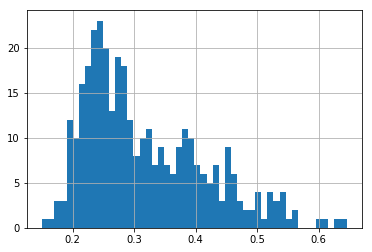

In [51]:
import matplotlib.pyplot as plt
burden[loans["type"] == "home"].hist(bins=50)
plt.show()

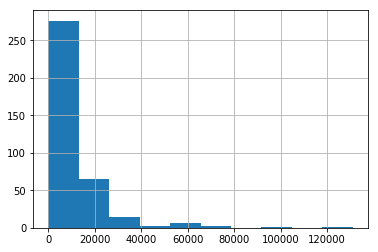

In [57]:
profit[loans["type"] == "auto"].hist()
plt.show()

In [59]:
home_profit = profit[loans["type"] == "auto"]
home_profit.quantile(0.25)
home_profit.quantile(0.5)

5648.357786036326

In [103]:
approval_rates = loans[["race", "approved", "income", "principal", "type"]].groupby(["race", "type"]).mean()

approval_rates

approved         income      principal
race            type                                            
asian           auto      0.500000   84272.200000   54188.300000
                home      0.666667   84501.666667  591792.000000
                personal  0.000000    3126.000000    1116.000000
black           auto      0.066667   31005.200000   18781.066667
                home      0.750000   82649.100000  562828.650000
                personal  0.583333   36111.500000   31544.166667
hispanic/latino auto      0.388889   47471.388889   22179.833333
                home      0.812500   47142.500000  361939.437500
                personal  0.500000   27814.625000   27656.125000
other           auto      0.571429   45755.428571   21505.428571
                home      0.833333   81904.666667  610059.166667
                personal  0.714286   47363.285714   55822.000000
white           auto      0.645161   70001.677419   28550.903226
                home      0.896552  116236.379310  808338.172414
                personal  0.363636   57272.818182   34872.181818

In [72]:
def compute_fpr_fnr(preds, labels, col, pos, neg):
    fp = sum((preds[col] == pos) & (labels[col] == neg))
    fp = fp/(sum(labels[col] == neg))
    
    fn = sum((preds[col] == neg) & (labels[col] == pos))
    fn = fn/(sum(labels[col] == pos))
    
    return fp, fn

In [73]:
# compute profit & burden distributions for each type of loan
   
year_payment = (1 + (loans["interest"]/100.))*((12*loans["principal"])/loans["term"])
profit = (loans["interest"]/100.)*loans["principal"]*(loans["term"]/12.)
burden = year_payment/loans["income"]
    

In [94]:
test_df = pd.DataFrame({"profit" : profit, "burden" : burden, "zip" : loans["zip"], "race" : loans["race"], "type" : loans["type"]})

In [95]:
home_loans = test_df[test_df["type"] == "home"]
personal_loans = test_df[test_df["type"] == "personal"]
car_loans = test_df[test_df["type"] == "auto"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b6c7790>,
      dtype=object)

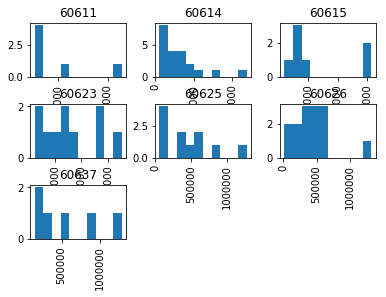

In [98]:
home_loans["profit"].hist(by=home_loans["zip"])

In [23]:
loans.columns

Index(['race', 'gender', 'date', 'zip', 'fed', 'income', 'type', 'term',
       'interest', 'principle', 'approved'],
      dtype='object')

In [31]:
panel_df = pd.get_dummies(loans["race"])
panel_df["zip"] = loans["zip"]

rate_df = panel_df.groupby(["zip"]).mean()

In [37]:
rate_df

,asian,black,hispanic/latino,other,white
zip,,,,,
60611,0.000000,0.062500,0.000000,0.187500,0.750000
60614,0.000000,0.173913,0.086957,0.130435,0.608696
60615,0.074074,0.629630,0.000000,0.111111,0.185185
60623,0.000000,0.428571,0.514286,0.057143,0.000000
60625,0.023256,0.069767,0.441860,0.162791,0.302326
60626,0.100000,0.300000,0.133333,0.133333,0.333333
60637,0.038462,0.846154,0.000000,0.076923,0.038462


In [39]:
rate_df["black"][60637]

0.8461538461538461

In [71]:
loans.to_csv("test_data.csv")

In [41]:
test = pd.read_csv("test_data.csv")

In [44]:
dummies = pd.get_dummies(test["race"])
dummies["zip"] = test["zip"]

In [46]:
rate_df = dummies.groupby(["zip"]).mean()

In [51]:
test.head()

,Unnamed: 0,race,gender,date,zip,fed,income,type,term,interest,principle,approved
0,0,black,female,2013-07-01,60615,0.09,79103,auto,72,3.724954,35656,True
1,1,black,female,2018-06-01,60637,1.82,15689,personal,18,16.792326,20109,True
2,2,hispanic/latino,male,2017-05-01,60625,0.91,40995,personal,18,15.947654,39045,True
3,3,other,female,2016-04-01,60611,0.37,141900,auto,60,6.561924,52079,True
4,4,hispanic/latino,male,2015-10-01,60625,0.12,96580,home,180,3.279388,677962,False
